# General settings

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
import sys
import math
from scipy.optimize import minimize, bisect
import numpy as np
from numpy import linalg as nplin

In [4]:
from dcpyps import dataset
from dcpyps import dcplots
from dcpyps import dcio

In [5]:
from dcpyps.ekdist import ekrecord
from dcpyps.ekdist import ekplot
from dcpyps import dcequations as dceq

# Load intervals from text file

In [12]:
rec = ekrecord.SingleChannelRecord()
infile = ["/DCPYPS/dcpyps/samples/scn/intervals1.scn"]
rec.load_SCN_file(infile)
rec.tres = 2e-6
print(rec)

Intervals loaded from SCN file: /DCPYPS/dcpyps/samples/scn/intervals1.scn
Total number of intervals = 251
Resolution for HJC calculations = 2.0 microseconds
Number of resolved intervals = 248
Number of time periods = 247

Number of open periods = 124
Mean and SD of open periods = 1.008073268 +/- 0.089536346 ms
Range of open periods from 1.000000047 ms to 2.001079381 ms

Number of shut intervals = 123
Mean and SD of shut periods = 0.853650330 +/- 0.933562638 ms
Range of shut periods from 0.006805163 ms to 5.266318098 ms


# Stability plots

RED- Open periods
GREEN- Shut intervals
BLUE- Popen


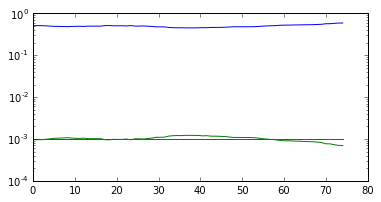

In [13]:
ekplot.plot_stability_intervals(rec)

# Dwell-time histograms

Mean and SD of 123 time periods = 0.85365 +/- 0.933563 ms
	Range from 0.00680516 to 5.26632 ms


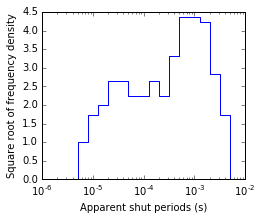

In [14]:
ekplot.plot_xlog_interval_histogram(rec.shint, rec.tres, shut=True)

## Fit multi-exponential pdf

##### Some useful functions

In [ ]:
def myexp(theta, X):
    tau, area = theta_unsqueeze(theta)
    X = np.asarray(X)
    y = np.array([])
    for t in np.nditer(X):
        y = np.append(y, np.sum((area / tau) * np.exp(-t / tau)))
    return y

def theta_unsqueeze(theta):
    theta = np.asarray(theta)
    tau, area = np.split(theta, [int(math.ceil(len(theta) / 2))])
    area = np.append(area, 1 - np.sum(area))
    return tau, area

def LL(theta, X):
    tau, area = theta_unsqueeze(theta)
    tau[tau < 1.0e-30] = 1e-8
    area[area > 1.0] = 0.99999
    area[area < 0.0] = 1e-6
    if np.sum(area[:-1]) >= 1: 
        area[:-1] = 0.99 * area[:-1] / np.sum(area[:-1])
    area[-1] = 1 - np.sum(area[:-1])
    
    d = np.sum( area * (np.exp(-min(X) / tau) - np.exp(-max(X)/ tau)))
    if d < 1.e-37:
        print (' ERROR in EXPLIK: d = ', d)
    X = np.asarray(X)
    s = 0.0
    for t in np.nditer(X):
        s -= math.log(np.sum((area / tau) * np.exp(-t / tau)))
    #theta = np.append(tau, area[:-1])
    return s + len(X) * math.log(d) #, theta

def number_per_comp(theta, X):
    tau, area = theta_unsqueeze(theta)
    f1 = np.sum(area * np.exp(-min(X) / tau))  #Prob(obs>ylow)
    f2 = np.sum(area * np.exp(-max(X) / tau))  #Prob(obs>yhigh)
    antrue = len(X) / (f1 - f2)
    en = antrue * area
    enout = [antrue * (1. - f1), antrue * f2]
    return en, enout

def print_exps(theta, X):
    tau, area = theta_unsqueeze(theta)
    numb, numout = number_per_comp(theta, X)
    for ta, ar, nu in zip(tau, area, numb):
        print('Tau = {0:.6f}; lambda (1/s)= {1:.6f}'.format(ta, 1.0 / ta))
        print('Area= {0:.6f}; number = {1:.3f}; amplitude (1/s) = {2:.3f}'.format(ar, nu, ar / ta))
    mean = np.sum(area * tau)
    print('\nOverall mean = {0:.6f}'.format(mean))
    print('Predicted true number of events = ', np.sum(numb))
    print('Number of fitted = ', len(X))
    print('Number below Ylow = {0:.3f}; number above Yhigh = {1:.3f}'.
          format(numout[0], numout[1]))

def errs_unsqueeze(sd):
    sd = np.asarray(sd)
    tsd, asd = np.split(sd, [int(math.ceil(len(sd) / 2))])
    asd = np.append(asd, asd[-1])
    return tsd, asd
    
    
def print_exps_with_errs(theta, apprSD):
    tau, area = theta_unsqueeze(theta)
    tsd, asd = errs_unsqueeze(apprSD)
    for ta, ar, td, ad in zip(tau, area, tsd, asd):
        print('Tau = {0:.6f}; approximate SD = {1:.6f}'.format(ta, td))
        print('Area= {0:.6f}; approximate SD = {1:.6f}'.format(ar, ad))


##### Fit dwell time histogram

In [ ]:
theta = [0.036, 1.1, 0.20]
print('Start LogLikelihood =', LL(theta, np.array(intervals)))

In [ ]:
res = minimize(LL, theta, args=np.array(intervals), method='Nelder-Mead')
print (res)

In [ ]:
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(111)
dcplots.xlog_hist_EXP_fit(ax, 0.0001, intervals, pdf=myexp, pars=res.x, shut=False) 
print_exps(res.x, intervals)

### Calculate approximate SD

In [ ]:
def hessian(theta, LLfunc, args):
    """
    """
    hess = np.zeros((theta.size, theta.size))
    print('hessian=', hessian)
    deltas = optimal_deltas(theta, LLfunc, args)
    print('optimal deltas=', deltas)
    # Diagonal elements of Hessian
    coe11 = np.array([theta.copy(), ] * theta.size) + np.diag(deltas)
    coe33 = np.array([theta.copy(), ] * theta.size) - np.diag(deltas)
    for i in range(theta.size):
        hess[i, i] = ((LLfunc(coe11[i], args) - 
            2.0 * LLfunc(theta, args) +
            LLfunc(coe33[i], args)) / (deltas[i]  ** 2))
    # Non diagonal elements of Hessian
    for i in range(theta.size):
        for j in range(theta.size):
            coe1, coe2, coe3, coe4 = theta.copy(), theta.copy(), theta.copy(), theta.copy()
            if i != j:                
                coe1[i] += deltas[i]
                coe1[j] += deltas[j]
                coe2[i] += deltas[i]
                coe2[j] -= deltas[j]
                coe3[i] -= deltas[i]
                coe3[j] += deltas[j]
                coe4[i] -= deltas[i]
                coe4[j] -= deltas[j]
                hess[i, j] = ((
                    LLfunc(coe1, args) -
                    LLfunc(coe2, args) -
                    LLfunc(coe3, args) +
                    LLfunc(coe4, args)) /
                    (4 * deltas[i] * deltas[j]))
    return hess

def optimal_deltas(theta, LLfunc, args):
    """ """

    Lcrit = 1.005 * LLfunc(theta, args)
    print('Lcrit=', Lcrit)
    deltas = 0.1 * theta
    print('start deltas=', deltas)
    L = LLfunc(theta + deltas, args)
    if L < Lcrit:
        count = 0
        while L < Lcrit and count < 100:
            deltas *= 2
            L = LLfunc(theta + deltas, args)
            count += 1
    elif L > Lcrit:
        count = 0
        while L > Lcrit and count < 100:
            deltas *= 0.5
            L = LLfunc(theta + deltas, args)
            count += 1
    return deltas

def covariance_matrix(theta, func, args, weightmode=1):
    """ """
    cov = nplin.inv(hessian(theta, func, args))
#    if weightmode == 1:
#        errvar = SSD(theta, (func, args))[0] / (args[0].size - theta.size)
#    else:
#        errvar = 1.0
    return cov #* errvar

def correlation_matrix(covar):
    correl = np.zeros((len(covar),len(covar)))
    for i1 in range(len(covar)):
        for j1 in range(len(covar)):
            correl[i1,j1] = (covar[i1,j1] / 
                np.sqrt(np.multiply(covar[i1,i1],covar[j1,j1])))
    return correl

In [ ]:
print(res.x)
print('Max log likelihood = ', res.fun)

In [ ]:
hess = hessian(res.x, LL, np.array(intervals))

In [ ]:
print(hess)

In [ ]:
cov = nplin.inv(hess)
print(cov)

In [ ]:
appSD = np.sqrt(cov.diagonal())
print(appSD)

In [ ]:
print(res.x)

In [ ]:
cormat = correlation_matrix(cov)

In [ ]:
print('Correlation matrix =\n', cormat)

In [ ]:
print_exps_with_errs(res.x, appSD)